# Forecast Model Analysis


In [11]:
import functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
df = pd.read_csv('../data/weight.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.head()

,weight_lbs,exer,food,avg_7d
date,,,,
2024-11-19,160.4,1,5,160.00
2024-11-20,159.2,1,6,160.00
2024-11-21,159.0,0,5,160.03
2024-11-22,159.2,1,6,159.86
2024-11-23,159.0,0,5,159.66


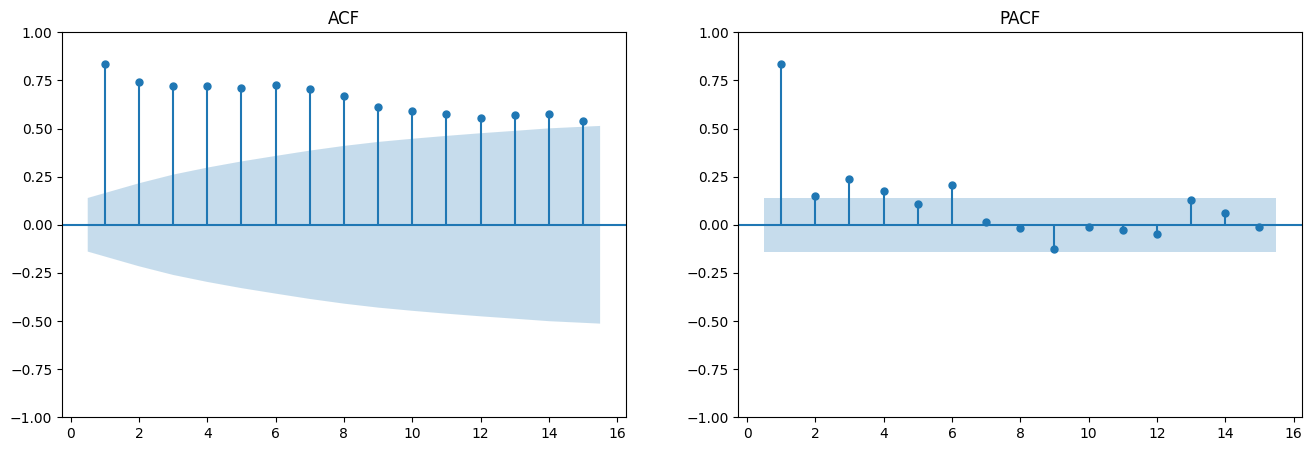

In [14]:
Y = df['weight_lbs']
sf.all_ac(Y)

In [15]:
sf.stationarity_test(Y)

('Non-Stationarity', 'Non-Stationarity')

                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  198
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -273.738
Date:                Thu, 05 Jun 2025   AIC                            555.476
Time:                        19:16:21   BIC                            568.609
Sample:                    11-19-2024   HQIC                           560.792
                         - 06-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3866      0.054     -7.184      0.000      -0.492      -0.281
ma.L1         -0.4174      0.066     -6.344      0.000      -0.546      -0.288
ma.L2         -0.2250      0.066     -3.393      0.0

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


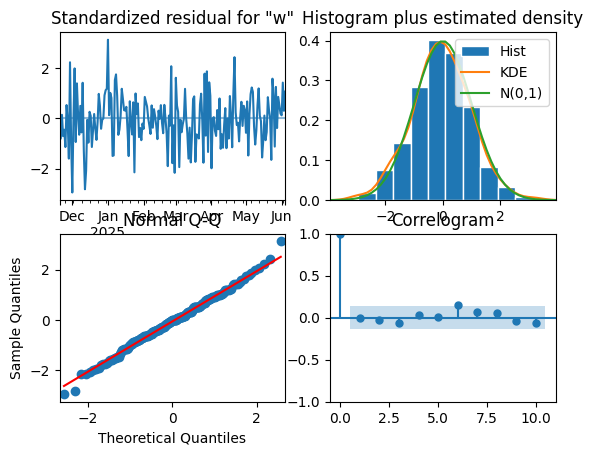

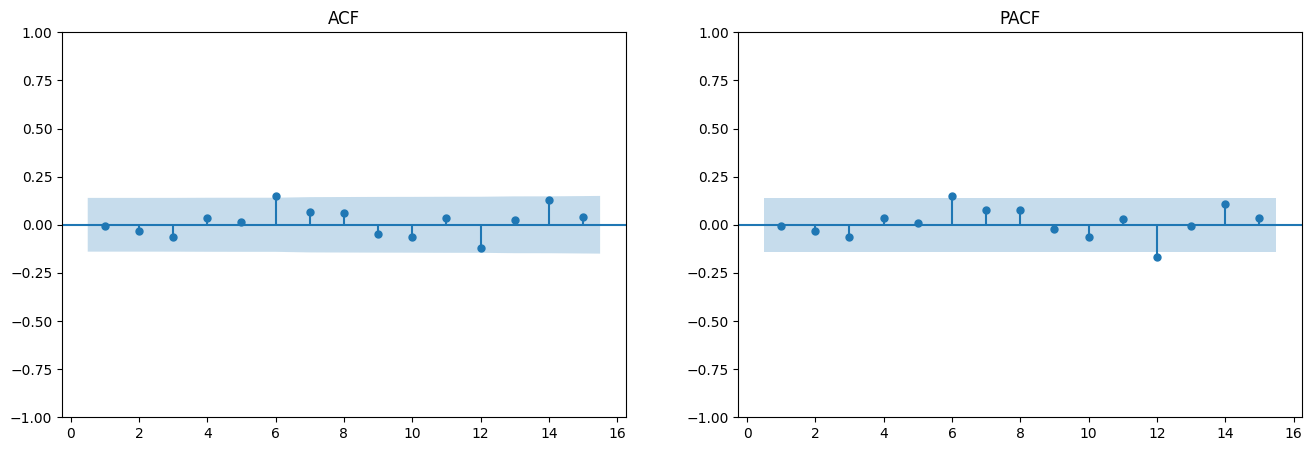

In [16]:
Y = df['weight_lbs']
x = df['food']*0.75 + df['exer']*0.25
model1 = SARIMAX(Y, order=(0,1,2), exog=x).fit(disp=False)
sf.diagnostic(model1)

In [17]:
import os
os.chdir('..')

In [18]:
pwd

'/Users/danielferreira/Documents/git/weight_control'

In [19]:
from utils.weight_analysis import wana
analysis = wana('data/weight.csv')
no_miss = analysis.df.dropna()

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  192
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -289.234
Date:                Thu, 05 Jun 2025   AIC                            586.469
Time:                        19:16:34   BIC                            599.478
Sample:                    11-25-2024   HQIC                           591.738
                         - 06-04-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
food_exercise_avg_7d    -2.2908      0.881     -2.599      0.009      -4.018      -0.563
ma.L1                   -0.4019      0.066     -6.072      0.000      -0.532      -0.272
ma.L2       

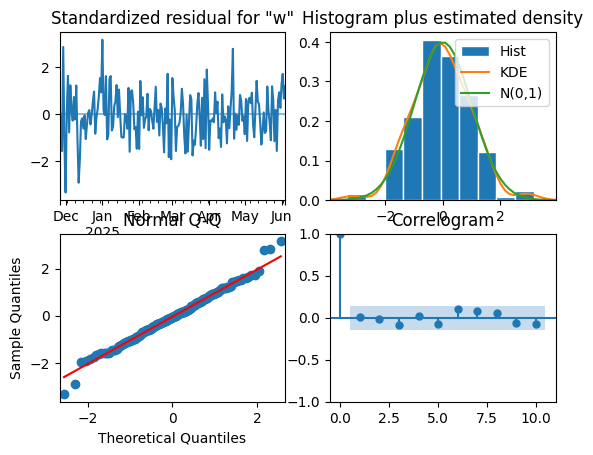

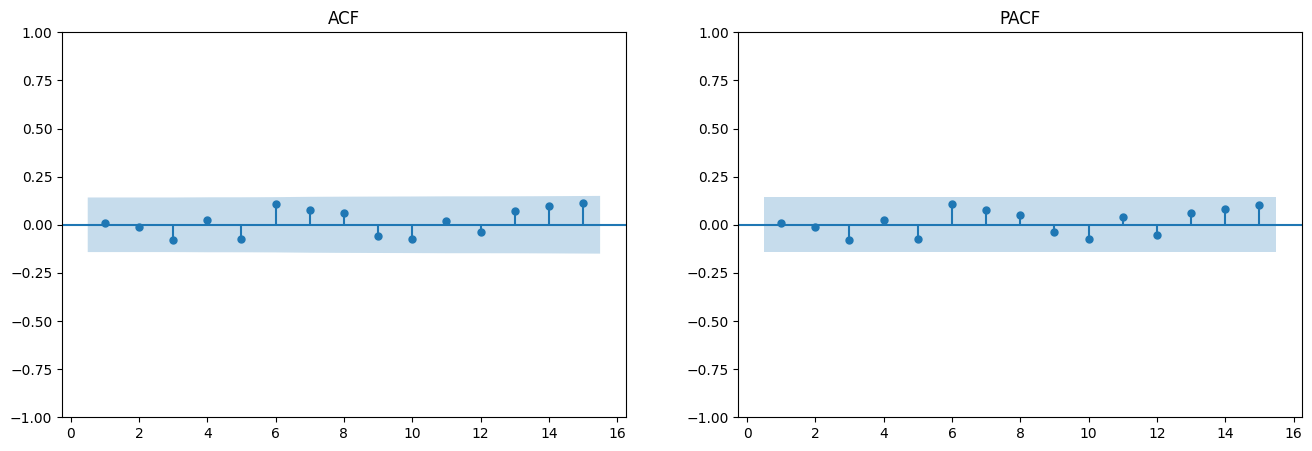

In [20]:
y = no_miss['weight_lbs']
x = no_miss['food_exercise_avg_7d']
model2 = SARIMAX(y, order=(0,1,2), exog=x).fit(disp=False)
sf.diagnostic(model2)

In [21]:
import json
os.chdir('forecast_model')

model_params = {
    "params": model2.params.to_dict(),
    "order": (0, 1, 2),
    "exog_mean": x.mean(),
    "exog_std": x.std()
}

with open('model_parameters.json', 'w') as f:
    json.dump(model_params, f)

In [28]:
future_steps = 7
first_pred_date = df.index.max()+pd.Timedelta(days=1)
with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)

In [34]:
future_dates = pd.date_range(start=first_pred_date, periods=future_steps, freq="D")
x_bad = np.full(future_steps, 0.25)
x_good = np.full(future_steps, 0.75)
dummy_endog = np.zeros(future_steps)

In [ ]:
model = SARIMAX(
    endog=dummy_endog,  # Placeholder endog array
    order=tuple(model_params["order"]),
    exog=x_bad  # Initial exog (can be replaced later)
)
model.update(model_params["params"])

# Predict for both scenarios using get_forecast
forecast_1 = model.get_forecast(steps=future_steps, exog=x_scenario_1).predicted_mean
forecast_2 = model.get_forecast(steps=future_steps, exog=x_scenario_2).predicted_mean

In [35]:
def predict_scenario(exog):
    model = SARIMAX(
        endog=dummy_endog,  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_bad)
predictions_2 = predict_scenario(x_good)

IndexError: index 3 is out of bounds for axis 0 with size 1

In [32]:
print(len(y))  # Length of the dependent variable
print(len(x))  # Length of the independent variable

192
192


In [ ]:

with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)


future_dates = pd.date_range(start=max, periods=future_steps, freq="D")

# Create exogenous variables for both scenarios
x_scenario_1 = np.full(future_steps, 0.25)
x_scenario_2 = np.full(future_steps, 0.75)

# Standardize exogenous variables (if needed)
x_scenario_1 = (x_scenario_1 - model_params["exog_mean"]) / model_params["exog_std"]
x_scenario_2 = (x_scenario_2 - model_params["exog_mean"]) / model_params["exog_std"]

# Initialize SARIMAX model with loaded coefficients
def predict_scenario(exog):
    model = SARIMAX(
        endog=[0],  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_scenario_1)
predictions_2 = predict_scenario(x_scenario_2)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_1, label="Scenario 1 (x=0.25)", color="blue")
plt.plot(future_dates, predictions_2, label="Scenario 2 (x=0.75)", color="orange")
plt.title("SARIMAX Predictions for Two Scenarios")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.legend()
plt.grid()
plt.show()

ValueError: endog and exog matrices are different sizes